In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
from tqdm import tqdm

In [3]:
df = pd.read_csv("../datas/interim/All Users Analysis/matched_edits_all.csv")
df.shape

(6922, 25)

In [23]:
# useful to do some quick edits for the df

In [4]:
print(df["user"].nunique(), "unique users found")
print()
print(df["user"].value_counts().head(10))  # Top users by edit count 
users_list = df['user'].unique().tolist() # List of all the users of the dataframe

2336 unique users found

user
LSGH                   372
TheDraperyFalls        254
Aleksandr Grigoryev    162
Toddy1                 147
UP9                    138
Yulia Romero           127
Irpen                  116
Seryo93                113
Dbachmann              111
Mzajac                  94
Name: count, dtype: int64


## Articles we are dealing with

It seems that in the 41 unique article found, none are from the full scale Russia invasion in Ukraine.

In [5]:
print(df['article'].nunique(), "unique article found") # how many unique value articles
print(df["article"].value_counts()) #how many rows I have for each unique article

40 unique article found
article
COVID-19_pandemic_in_Ukraine_analysis                              1322
History_of_Ukraine_analysis                                        1175
Crimea_analysis                                                    1139
Annexation_of_Crimea_by_the_Russian_Federation_analysis             502
2004_Ukrainian_presidential_election_analysis                       425
Football_in_Ukraine_analysis                                        268
Bessarabia_analysis                                                 255
2014_pro-Russian_unrest_in_Ukraine_analysis                         249
Communist_Party_of_the_Soviet_Union_analysis                        217
Christianity_in_Russia_analysis                                     172
History_of_Christianity_in_Ukraine_analysis                         168
Flag_of_Ukraine_analysis                                            113
Alexander_II_of_Russia_analysis                                     101
Eastern_Front_(World_War_II)_ana

In [6]:
df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

# Drop the rows without valid year or weaponised label..
df = df.dropna(subset=["year", "weaponised"])

# Ensure correct types
df["year"] = df["year"].astype(int)

# Normalizing the weaponised field because there are some capitalised and soem not --> lowercase and strip
df["weaponised"] = df["weaponised"].astype(str).str.strip().str.lower()
df["weaponised"] = df["weaponised"].replace({
    "true": "Weaponised",
    "false": "Not Weaponised",
    "unknown": "Unknown",
    "weaponised": "Weaponised",
    "not weaponised": "Not Weaponised"
})

df["weaponised"].unique()

array(['Not Weaponised', 'Weaponised'], dtype=object)

In [9]:
ipv4_ipv6_pattern = (
    r"^(?:\d{1,3}\.){3}\d{1,3}$|"  # IPv4
    r"^(?:[A-Fa-f0-9]{0,4}:){2,7}[A-Fa-f0-9]{0,4}$"  # IPv6
)
df["is_anon"] = df["user"].str.contains(ipv4_ipv6_pattern, na=False)
df['is_bot'] = df['user'].str.contains('bot', case=False, na=False)

all_users_data = {
    # Overall dataset size
    "total_edits": len(df),
    "total_unique_users": df["user"].nunique(),
    "number_unique_articles": df["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df.loc[df["is_bot"], "user"].nunique(),
    "num_anonymous_users": df.loc[df["is_anon"], "user"].nunique(),
    "num_registered_users": df.loc[~df["is_bot"] & ~df["is_anon"], "user"].nunique(),

    # Edit counts by user type
    "num_bot_edits": int(df["is_bot"].sum()),
    "num_anonymous_edits": int(df["is_anon"].sum()),
    "num_registered_edits": int(len(df) - (df["is_bot"].sum() + df["is_anon"].sum())),

    # Weaponisation counts
    "weaponised_edits": int((df["weaponised"] == "Weaponised").sum()),
    "non_weaponised_edits": int((df["weaponised"] == "Not Weaponised").sum())
}

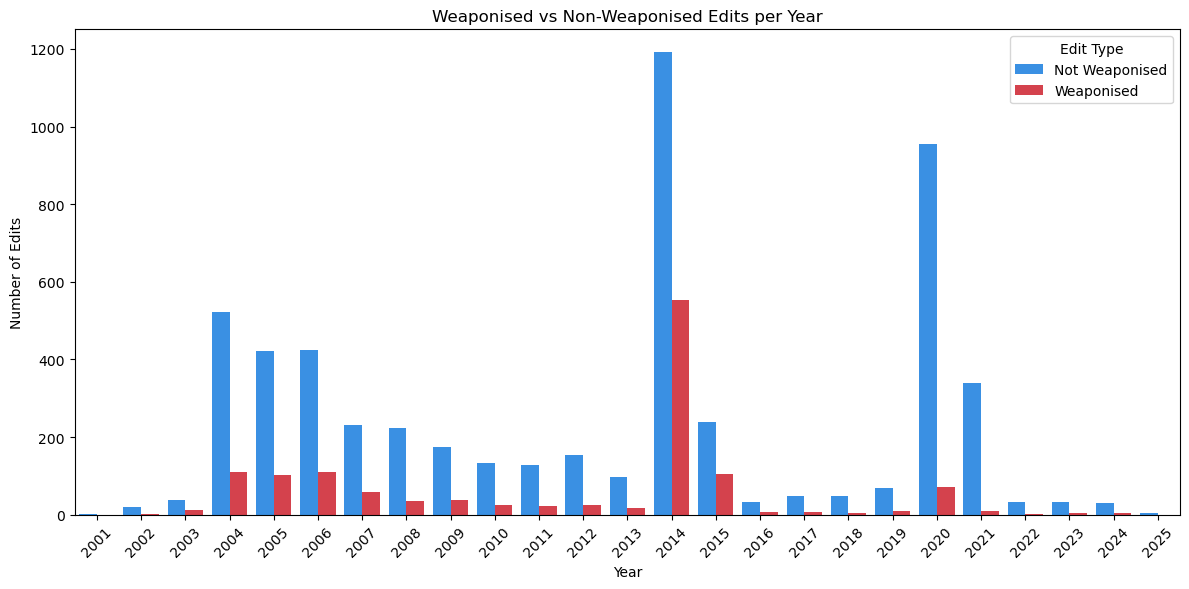

In [10]:
custom_palette = {
    "Weaponised": "#ed2939",      # red
    "Not Weaponised": "#1e90ff",   # royal blue
}

df_counts = df.groupby(["year", "weaponised"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_counts,
    x="year",
    y="count",
    hue="weaponised",
    palette=custom_palette
)

plt.title("Weaponised vs Non-Weaponised Edits per Year")
plt.xlabel("Year")
plt.ylabel("Number of Edits")
plt.legend(title="Edit Type")
plt.xticks(rotation=45)
plt.tight_layout()
fig_title = 'Weaponised vs Non-Weaponised Edits per Year'
plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches='tight')
plt.show()

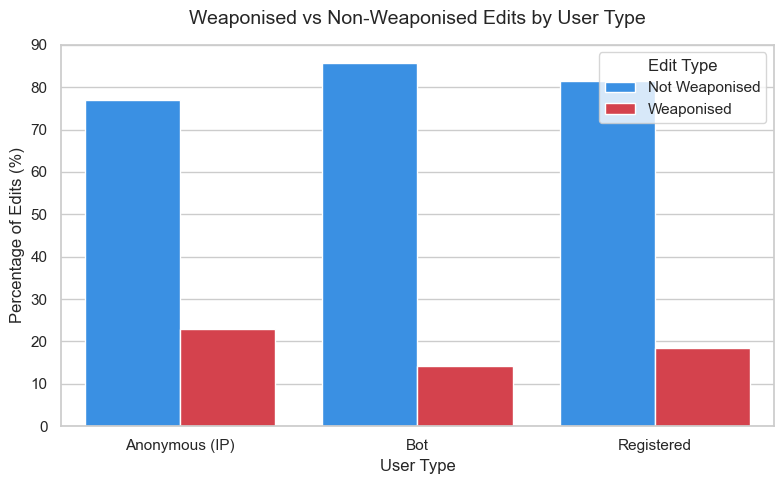

In [11]:
# Tag each edit with its user type
def get_user_type(row):
    if row["is_anon"]:
        return "Anonymous (IP)"
    elif row["is_bot"]:
        return "Bot"
    else:
        return "Registered"

df['user_type'] = df.apply(get_user_type, axis=1)

# Count how many edits of each type are weaponised / non-weaponised
comparison = (
    df.groupby(["user_type", "weaponised"])
    .size()
    .reset_index(name="count")
)

# Compute total edits per user type and percentage of weaponised edits
totals = comparison.groupby("user_type")["count"].sum().reset_index(name="total")
comparison = comparison.merge(totals, on="user_type")
comparison["percentage"] = (comparison["count"] / comparison["total"]) * 100

custom_palette = {
    "Weaponised": "#ed2939",      # red
    "Not Weaponised": "#1e90ff",   # royal blue
}

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=comparison,
    x="user_type",
    y="percentage",
    hue="weaponised",
    palette=custom_palette
)

plt.title("Weaponised vs Non-Weaponised Edits by User Type", fontsize=14, pad=15)
plt.xlabel("User Type", fontsize=12)
plt.ylabel("Percentage of Edits (%)", fontsize=12)
plt.legend(title="Edit Type")
plt.tight_layout()
fig_title = 'Weaponised vs Non-Weaponised Edits by User Type'
plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
top_users = (
    df
    .groupby("user")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_users_list = list(top_users)
top_users_list

['LSGH',
 'TheDraperyFalls',
 'Aleksandr Grigoryev',
 'Toddy1',
 'UP9',
 'Yulia Romero',
 'Irpen',
 'Seryo93',
 'Dbachmann',
 'Mzajac']

In [14]:
# jsut a subset of data for now. subset of df but with only the edits made by the top_users.
df_top = df[df["user"].isin(top_users_list)]

# count edits per (user, year, weaponised)
grouped = (
    df_top.groupby(["user", "year", "weaponised"])
    .size()
    .reset_index(name="count")
)

/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_84311/947874969.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

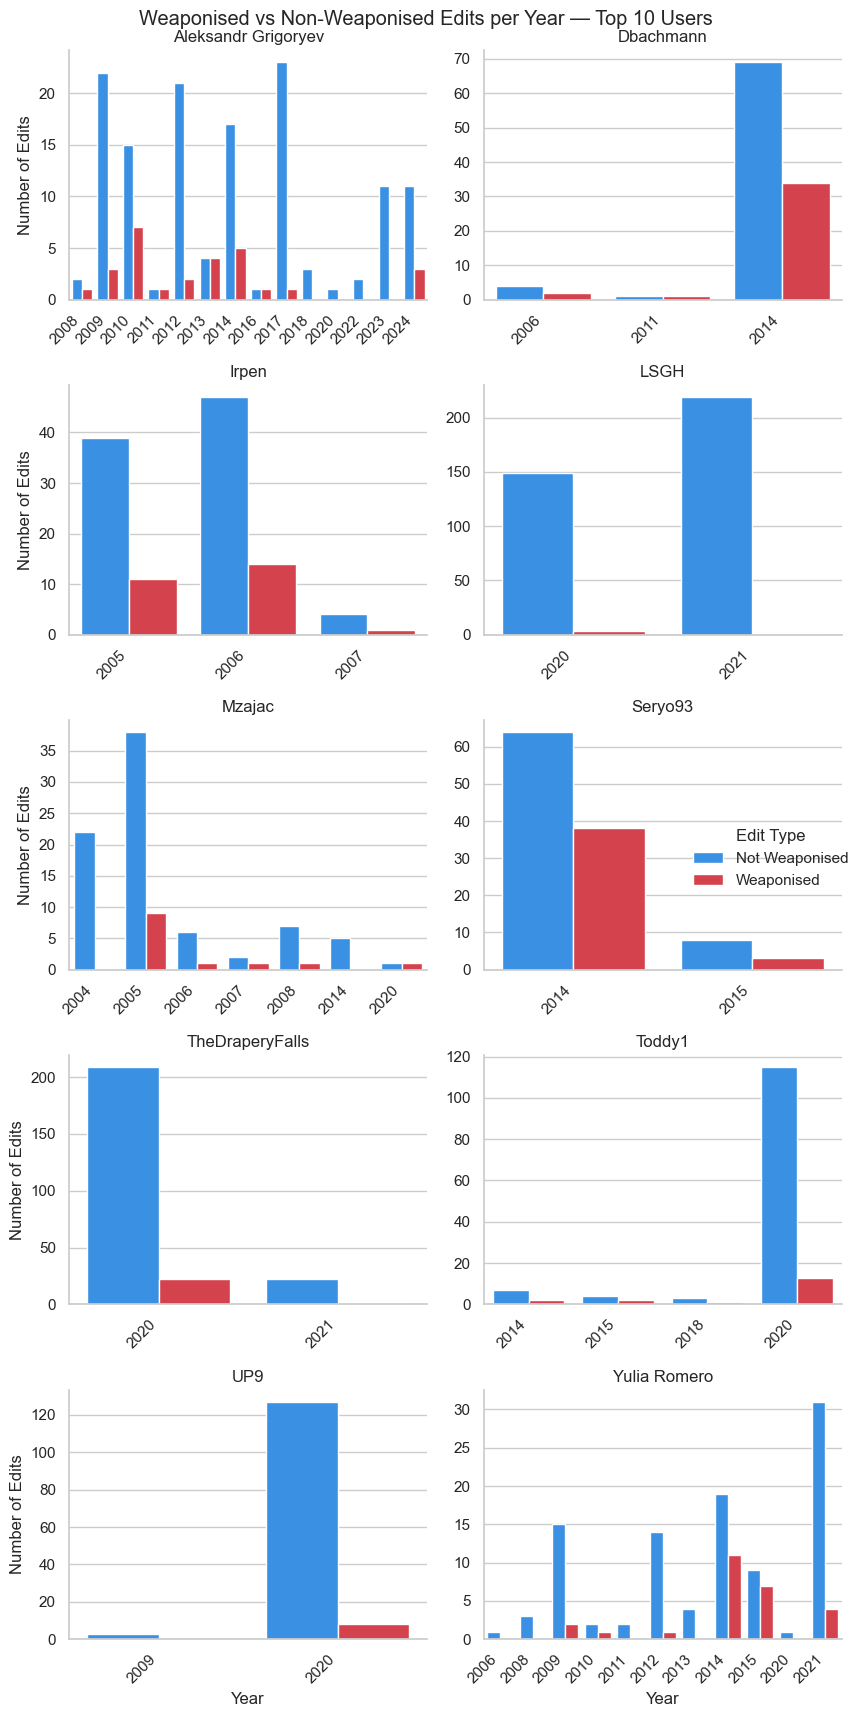

In [52]:
# Ensure seaborn style
custom_palette = {
    "Weaponised": "#ed2939",      # red
    "Not Weaponised": "#1e90ff"   # blue
}
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Create the barplot
g = sns.FacetGrid(grouped, col="user", col_wrap=2, height=3.5, sharey=False, sharex=False)
g.map_dataframe(sns.barplot, x="year", y="count", hue="weaponised", palette=custom_palette, errorbar=None)
g.add_legend(title="Edit Type")

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Number of Edits")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Weaponised vs Non-Weaponised Edits per Year — Top 10 Users")

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
fig_title = 'Weaponised vs Non-Weaponised Edits per Year — Top 10 Users'
plt.xticks(rotation=45, ha='right')
plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches='tight')
plt.show()

In [60]:
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

URL = "https://en.wikipedia.org/w/api.php"


def get_user_info(username, max_retries=3, backoff=1.0):
    session = requests.Session()
    session.headers.update(HEADERS)

    params = {
        "action": "query",
        "list": "users",
        "ususers": username,
        "usprop": "blockinfo|groups|editcount|registration|emailable|gender",
        "format": "json"
    }

    for attempt in range(max_retries):
        try:
            response = session.get(url=URL, params=params, timeout=10)

            if response.status_code != 200:
                return {"user": username, "error": f"HTTP {response.status_code}"}

            try:
                data = response.json()
            except ValueError:
                return {"user": username, "error": "Invalid JSON response"}

            if "query" in data and "users" in data["query"]:
                return data["query"]["users"][0]
            else:
                return {"user": username, "error": "Missing 'users' in response"}

        except Exception as e:
            time.sleep(backoff * (2 ** attempt))  # exponential backoff

    return {"user": username, "error": f"Failed after {max_retries} attempts"}

In [65]:
# Collect results with progress bar
user_metadata = []
for user in tqdm(top_users_list, desc="Fetching user metadata", unit="user"):
    info = get_user_info(user)
    user_metadata.append(info)


Fetching user metadata: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62user/s]


In [66]:
top_users_metadata = pd.DataFrame(user_metadata)

top_users_metadata.to_csv("../datas/interim/All Users Analysis/all_user_profiles.csv", index=False)
top_users_metadata

,userid,name,editcount,registration,groups,emailable,gender
0,38910429,LSGH,59406,2020-04-02T10:23:20Z,"[extendedconfirmed, *, user, autoconfirmed]",,unknown
1,15458982,TheDraperyFalls,11312,2011-10-04T07:05:08Z,"[extendedconfirmed, *, user, autoconfirmed, oa...",,male
2,2425663,Aleksandr Grigoryev,160546,2006-10-08T02:40:18Z,"[autoreviewer, extendedconfirmed, reviewer, *,...",,male
3,3132940,Toddy1,52165,2006-12-30T16:29:31Z,"[autoreviewer, extendedconfirmed, reviewer, ro...",,unknown
4,9761029,UP9,390,2009-05-25T17:33:35Z,"[*, user, autoconfirmed, oathauth-twofactorauth]",,unknown
5,693352,Yulia Romero,69430,2006-01-21T22:40:45Z,"[autoreviewer, extendedconfirmed, reviewer, *,...",,unknown
6,69761,Irpen,32604,2004-06-03T04:10:48Z,"[*, user, autoconfirmed, oathauth-twofactorauth]",,unknown
7,9847609,Seryo93,4843,2009-06-06T11:56:11Z,"[extendedconfirmed, *, user, autoconfirmed, oa...",,male
8,86857,Dbachmann,227714,2004-07-21T10:44:35Z,"[*, user, autoconfirmed]",,unknown
9,61482,Mzajac,66545,2004-06-08T22:15:05Z,"[autoreviewer, extendedconfirmed, *, user, aut...",,unknown


# Info about user's contributions

In [22]:
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def get_all_user_contribs(username, max_edits=None):
    """
    Retrieve *all* contributions for a user via Wikipedia API pagination.
    Optionally limit total retrieved edits with `max_edits`.
    """
    session = requests.Session()
    session.headers.update(HEADERS)

    URL = "https://en.wikipedia.org/w/api.php"
    PARAMS = {
        "action": "query",
        "format": "json",
        "list": "usercontribs",
        "ucuser": username,
        "ucprop": "ids|title|timestamp|comment|size|flags",
        "uclimit": 500  # maximum allowed per query
    }

    all_edits = []
    cont = True
    uccontinue = None

    while cont:
        if uccontinue:
            PARAMS["uccontinue"] = uccontinue

        R = session.get(URL, params=PARAMS)
        R.raise_for_status()
        DATA = R.json()

        contribs = DATA.get("query", {}).get("usercontribs", [])
        for c in contribs:
            c["username"] = username
        all_edits.extend(contribs)

        uccontinue = DATA.get("continue", {}).get("uccontinue")
        cont = bool(uccontinue)

        # optional stopping condition
        if max_edits and len(all_edits) >= max_edits:
            all_edits = all_edits[:max_edits]
            break

        time.sleep(0.5)  # polite delay

    return all_edits

all_contribs = []

for user in top_users_list:
    print(f"Fetching all contributions for: {user}")

    user_edits = get_all_user_contribs(user)
    print(f"  → Retrieved {len(user_edits)} total edits")

    all_contribs.append(user_edits)
    time.sleep(1)

top_user_contribs_df = pd.DataFrame(all_contribs)

cols = ["username", "userid", "pageid", "revid", "parentid", "ns", "title", "timestamp", "comment", "size"]
top_user_contribs_df = top_user_contribs_df.reindex(columns=[c for c in cols if c in top_user_contribs_df.columns])

Fetching all contributions for: LSGH
  → Retrieved 59468 total edits
Fetching all contributions for: TheDraperyFalls
  → Retrieved 11163 total edits
Fetching all contributions for: Aleksandr Grigoryev
  → Retrieved 158746 total edits
Fetching all contributions for: Toddy1
  → Retrieved 51582 total edits
Fetching all contributions for: UP9
  → Retrieved 391 total edits
Fetching all contributions for: Yulia Romero
  → Retrieved 68733 total edits
Fetching all contributions for: Irpen
  → Retrieved 31012 total edits
Fetching all contributions for: Seryo93
  → Retrieved 4711 total edits
Fetching all contributions for: Dbachmann
  → Retrieved 225138 total edits
Fetching all contributions for: Mzajac
  → Retrieved 65109 total edits


In [34]:
flat_contribs = [edit for user_list in all_contribs for edit in user_list]

top_user_contribs_df = pd.DataFrame(flat_contribs)

cols = ["username", "userid", "pageid", "revid", "parentid", "ns",
        "title", "timestamp", "comment", "size"]

top_user_contribs_df = top_user_contribs_df.reindex(
    columns=[c for c in cols if c in top_user_contribs_df.columns]
)
top_user_contribs_df

,username,userid,pageid,revid,parentid,ns,title,timestamp,comment,size
0,LSGH,38910429,63260687,1075136185,1074964872,0,COVID-19 pandemic in Bahrain,2022-03-04T04:03:16Z,Updating number of cases in infobox,64532
1,LSGH,38910429,63339598,1075135994,1074964830,10,Template:COVID-19 pandemic data/South Africa m...,2022-03-04T04:01:40Z,Adding number of cases for March 03,23607
2,LSGH,38910429,63281706,1075022468,1074969215,0,COVID-19 pandemic in Latvia,2022-03-03T13:19:02Z,Updating number of cases in infobox,153418
3,LSGH,38910429,63353757,1075022344,1074969128,10,Template:COVID-19 pandemic data/Latvia medical...,2022-03-03T13:18:11Z,Adding number of cases for March 03,19318
4,LSGH,38910429,63262762,1075022265,1074414768,0,COVID-19 pandemic in Andorra,2022-03-03T13:17:26Z,Updating number of cases in infobox,35796
...,...,...,...,...,...,...,...,...,...,...
676048,Mzajac,61482,43875,4969037,4969004,1,Talk:Phoneme,2004-08-02T19:58:47Z,,7725
676049,Mzajac,61482,43875,4969004,4968986,1,Talk:Phoneme,2004-08-02T19:52:25Z,,7718
676050,Mzajac,61482,100730,4006896,3990058,0,Winnipeg,2004-06-08T23:10:07Z,/* Personalities born in Winnipeg: */,14611
676051,Mzajac,61482,6059245,4065465,3989933,0,Canadian identity,2004-06-08T23:04:27Z,/* Reference */,14272


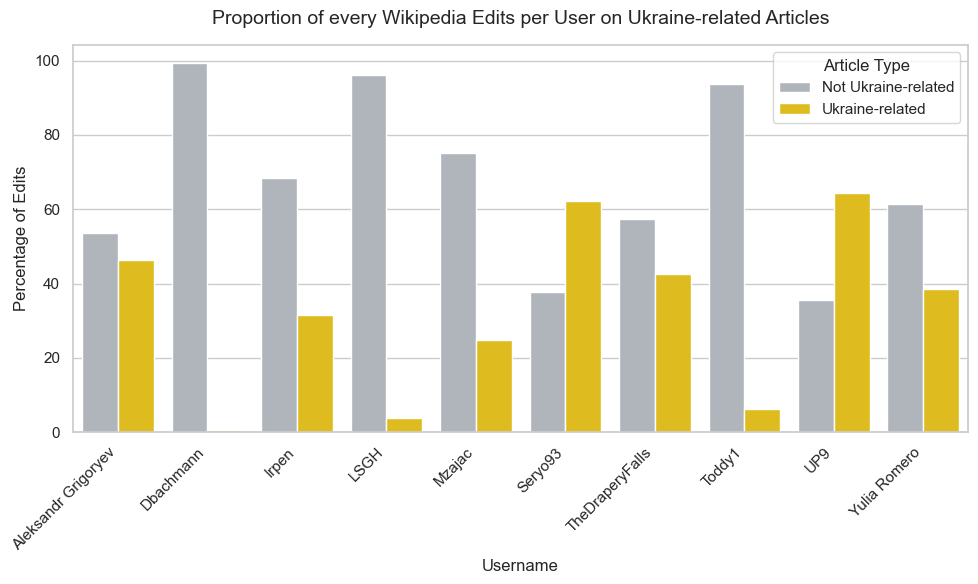

In [37]:
ukraine_keywords_small = [
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia", "eastern",
    "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow", "kremlin", "soviet"
]

ukraine_keywords_large = [
    # core country and people
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia",
    "eastern", "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow",
    "kremlin", "soviet",

    # politics & government
    "verkhovna rada", "president", "prime minister", "parliament", "government", "cabinet", "federation",
    "referendum", "annexation", "independence", "revolution", "reforms", "corruption", "sanctions",
    "occupation", "treaty", "agreement", "ceasefire", "negotiations", "elections", "coup", "unification",

    # geography & regions
    "zaporizhzhia", "mariupol", "kharkiv", "kherson", "mykolaiv", "chernihiv", "sumy", "poltava", "vinnytsia",
    "lviv", "ivano-frankivsk", "ternopil", "lutsk", "uzhhorod", "dnipropetrovsk", "donetsk oblast",
    "luhansk oblast", "transcarpathia", "prykarpattia", "galicia", "novorossiya", "black sea", "azov sea",

    # historical references
    "kyivan rus", "tsar", "imperial", "empire", "ussr", "communist", "lenin", "stalin", "bolshevik",
    "cold war", "perestroika", "glasnost", "collapse", "partition", "catherine the great", "brezhnev",
    "chernobyl", "orange revolution", "revolution of dignity", "holodomor", "soviet union",

    # war and military
    "invasion", "occupation", "annexed", "frontline", "offensive", "defense", "army", "forces", "military",
    "russian troops", "ukrainian forces", "separatist", "rebels", "paramilitary", "nato", "eu", "un", "war",
    "conflict", "shelling", "bombing", "airstrike", "occupation forces", "mobilization", "martial law",

    # culture, identity & language
    "language", "identity", "heritage", "culture", "orthodox", "church", "patriarch", "ukrainian language",
    "russian language", "minority", "bilingual", "autonomy", "nationalism", "independence day", "flag",
    "anthem", "symbol", "national identity", "sovereignty",

    # current / modern references
    "donbas war", "russian invasion", "ukrainian front", "crimea bridge", "moskva cruiser", "ukrainian army",
    "russian army", "zelensky", "kremlin propaganda", "occupation administration", "territorial defense",
    "european union", "eu membership", "nato membership", "nato expansion", "eu sanctions", "ukraine war",
    "full-scale invasion", "special military operation", "mobilisation", "referendum in crimea",

    # other
    "gas pipeline", "north stream", "energy crisis", "grain corridor", "black sea fleet", "peace talks",
    "donetsk people's republic", "luhansk people's republic", "kyiv oblast", "liberation", "resistance",
    "occupation zone", "ukrainian refugees", "mariupol steel plant", "azovstal", "bucha", "irpin", "kharkiv offensive"
]

def is_ukraine_related(title):
    if not isinstance(title, str):
        return False
    title_lower = title.lower()
    return any(kw in title_lower for kw in ukraine_keywords_small)

top_user_contribs_df["ukraine_related"] = top_user_contribs_df["title"].apply(is_ukraine_related)

user_distribution = (
    top_user_contribs_df
    .groupby(["username", "ukraine_related"])
    .size()
    .reset_index(name="count")
)

# Convert to percentages
user_distribution["percentage"] = (
    user_distribution.groupby("username")["count"].transform(lambda x: 100 * x / x.sum())
)

sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Define a clear color palette (blue = Ukraine-related, grey = not related)
palette = {True: "#fed000", False: "#adb5bd"}

ax = sns.barplot(
    data=user_distribution,
    x="username",
    y="percentage",
    hue="ukraine_related",
    palette=palette
)

plt.title("Proportion of every Wikipedia Edits per User on Ukraine-related Articles", fontsize=14, pad=15)
plt.xlabel("Username", fontsize=12)
plt.ylabel("Percentage of Edits", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Fix legend: ensure correct order and labels
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Ukraine-related", "Not Ukraine-related"] if labels[0] == "True" else ["Not Ukraine-related", "Ukraine-related"]
plt.legend(handles=handles, labels=new_labels, title="Article Type", loc="upper right")
fig_title = "Proportion of every Wikipedia Edits per Top 10 Registered User on Ukraine-related Articles"
plt.savefig(f"../plots/All Users Analysis/{fig_title}_small.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [80]:
user_distribution = (
    top_user_contribs_df
    .groupby(["username", "ukraine_related", "title"])
    .size()
    .reset_index(name="count")
)

user_distribution = user_distribution[user_distribution['ukraine_related'] == True]
user_distribution_article_list = user_distribution['title'].unique().tolist()
for user in top_users_list:
    user_distribution_specific = user_distribution[user_distribution['username'] == user]
    print(f"for user : {user}, we have {user_distribution_specific['count'].sum()} edits for {user_distribution_specific['title'].nunique()} of articles.")
    print()

for user : LSGH, we have 2264 edits for 19 of articles.

for user : TheDraperyFalls, we have 4750 edits for 395 of articles.

for user : Aleksandr Grigoryev, we have 73656 edits for 5988 of articles.

for user : Toddy1, we have 3253 edits for 387 of articles.

for user : UP9, we have 252 edits for 19 of articles.

for user : Yulia Romero, we have 26475 edits for 2886 of articles.

for user : Irpen, we have 9808 edits for 1023 of articles.

for user : Seryo93, we have 2937 edits for 380 of articles.

for user : Dbachmann, we have 1607 edits for 472 of articles.

for user : Mzajac, we have 16221 edits for 3490 of articles.



In [78]:
# jsut a subset of data for now. subset of df but with only the edits made by the top_users.
df_top = df[df["user"].isin(top_users_list)]

# count edits per (user, year, weaponised)
grouped = (
    df_top.groupby(["user", "article", "weaponised"])
    .size()
    .reset_index(name="count")
)

grouped = grouped[grouped['user'] == 'Seryo93']
user_distribution_specific = user_distribution[user_distribution['username'] == 'Dbachmann']
user_distribution_specific

,username,ukraine_related,title,count
73782,Dbachmann,True,1682 Moscow uprising,1
73783,Dbachmann,True,18th century Russia,1
73784,Dbachmann,True,1945 Moscow Victory Parade,1
73785,Dbachmann,True,2002 Russian census,1
73786,Dbachmann,True,2015 Russian Sukhoi Su-24 shootdown,2
...,...,...,...,...
74249,Dbachmann,True,Ukrainians in the United Kingdom,1
74250,Dbachmann,True,User talk:Crzrussian,1
74251,Dbachmann,True,User talk:Electionworld/Atlas:Russia,1
74252,Dbachmann,True,Wikipedia:Articles for deletion/Assumption by ...,1


## New section

The goal of this next section is to see the magnitude of the edits between only weaponsing edits by registered user vs weaponsing edits done by IP user. In order to do that, we will compute the len(initial_version) - len(changed_version) to see if weap edits are more concise than non weap edits and if IP adress are more concise than registered edits.

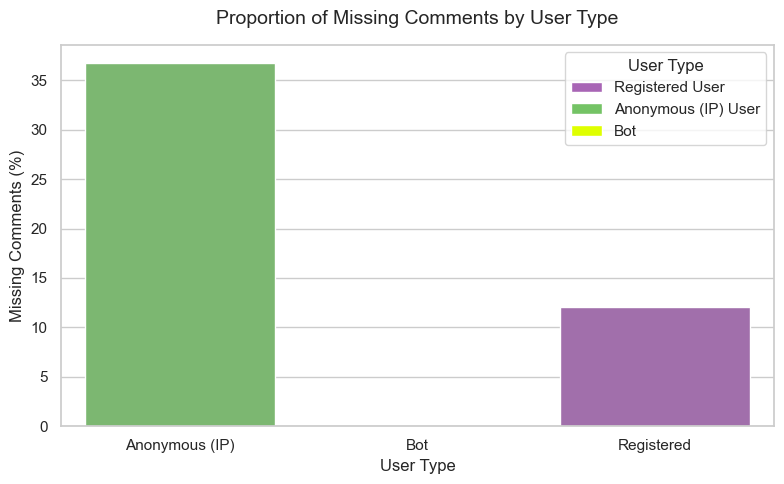

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ Count missing comments per user_type
missing = (
    df[df["comment"].isna()]
    .groupby("user_type")
    .size()
    .reset_index(name="missing_count")
)

# 2️⃣ Count total rows (edits) per user_type
total = (
    df.groupby("user_type")
    .size()
    .reset_index(name="total_count")
)

# 3️⃣ Merge and compute percentage
comparison = missing.merge(total, on="user_type", how="right").fillna(0)
comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100

# 4️⃣ Filter only Registered and Anonymous (IP)
comparison = comparison[comparison["user_type"].isin(["Registered", "Anonymous (IP)", "Bot"])]

# 5️⃣ Define colors for clarity
custom_palette = {
    "Registered": "#a865b5",      # red
    "Anonymous (IP)": "#74c365",   # royal blue
    "Bot": "#dfff00"
}

# 6️⃣ Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.barplot(
    data=comparison,
    x="user_type",
    y="missing_percentage",
    hue='user_type',
    palette=custom_palette
)

plt.title("Proportion of Missing Comments by User Type", fontsize=14, pad=15)
plt.xlabel("User Type", fontsize=12)
plt.ylabel("Missing Comments (%)", fontsize=12)
plt.tight_layout()

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#a865b5", label="Registered User"),
    Patch(facecolor="#74c365", label="Anonymous (IP) User"),
    Patch(facecolor="#dfff00", label="Bot")
]
plt.legend(
    handles=legend_elements,
    title="User Type",
    loc="upper right",
    frameon=True
)

fig_title = "Proportion of Missing Comments by User Type"
plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
df.to_csv('../datas/final/complete:matched_edits_all.csv', index=False)